<a href="https://colab.research.google.com/github/Murcha1990/AppliedDS_DPO_2024/blob/main/Lesson4_NLP4/AiEdu_Spell_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
# Установка библиотек
!pip install datasets
!apt install git-lfs
!pip install transformers
!pip install sentencepiece
!pip install rouge_score

In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

## Предобученный spell corrector для русского языка

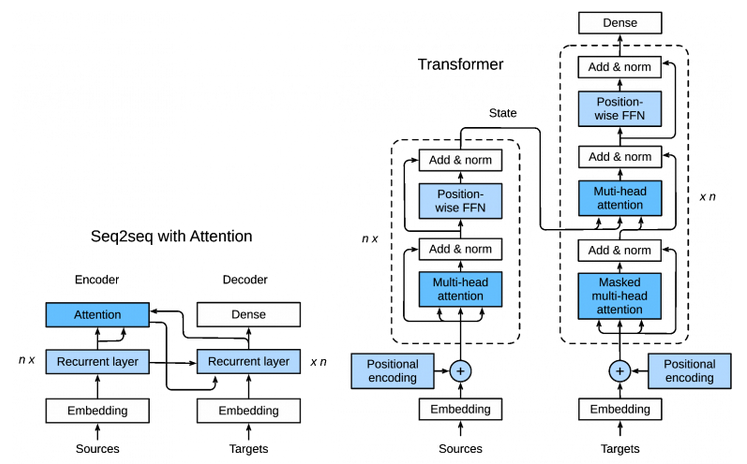

In [ ]:
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer

path_to_model = "ai-forever/RuM2M100-1.2B"

model = M2M100ForConditionalGeneration.from_pretrained(path_to_model)
tokenizer = M2M100Tokenizer.from_pretrained(path_to_model, src_lang="ru", tgt_lang="ru")

sentence = "паявифшись в МГТУ я был удивлен никого необноружив там…"

encodings = tokenizer(sentence, return_tensors="pt")
generated_tokens = model.generate(
        **encodings, forced_bos_token_id=tokenizer.get_lang_id("ru"))
answer = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
print(answer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/465k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/489k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

['появившись в МГТУ я был удивлен никого не обнаружив там...']


In [ ]:
sentence = "У лукаморья дуб зиленый, залотая цепь на дупе том"
# sentence = "Когда я бил в Париже, я видел Эфелеву башню"
# sentence = "превед медвед!"

encodings = tokenizer(sentence, return_tensors="pt")
generated_tokens = model.generate(
        **encodings, forced_bos_token_id=tokenizer.get_lang_id("ru"))
answer = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
print(answer)

['У лукоморья дуб зеленый, золотая цепь над дуплетом']


## Обучение / дообучение модели для русского языка

In [ ]:
# Импорт библиотек
import numpy as np
from datasets import Dataset
import tensorflow as tf
import nltk
from transformers import T5TokenizerFast, Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
import torch
from transformers.optimization import Adafactor, AdafactorSchedule
from datasets import load_dataset, load_metric

In [ ]:
# загрузка параметров
raw_datasets = load_dataset("xsum")
metric = load_metric("rouge")
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
<ipython-input-

True

In [ ]:
# # Ввести свой ключ huggingface hyb
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
# Определение параметров
REPO = "t5-russian-spell"  # Введите название название репозитория
MODEL_NAME = "UrukHan/t5-russian-spell" # Введите название выбранной модели из хаба
MAX_INPUT = 256  # Введите максимальную длинну входных данных  в токенах (длинна входных фраз в словах (можно считать полслова токен))
MAX_OUTPUT  = 256 # Введите максимальную длинну прогнозов в токенах (можно уменьшить для задач суммризации или других задач где выход короче)
BATCH_SIZE = 8
DATASET = 'UrukHan/t5-russian-spell_I'   # Введите наазвание название датасета

In [ ]:
# Загрузка датасета
data = load_dataset(DATASET)

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
tokenizer = T5TokenizerFast.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

In [ ]:
model.config.max_length = MAX_OUTPUT  # по умолчанию 20, поэтому во всех моделях прогнозы обрезаются выходные последовательности
# Закоментить после первого сохранения в репозиторий свой необязательно

#tokenizer.push_to_hub(repo_name)

In [ ]:
train = data['train']
test = data['test'].train_test_split(0.02)['test']  # Уменьшаем тестовую выборку чтоб не ждать долго расчет ошибок между эпохами

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model) #return_tensors="tf"

In [ ]:
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  # Replace -100 in the labels as we can't decode them.
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # Rouge expects a newline after each sentence
  decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
  decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

  result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
  # Extract a few results
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

  # Add mean generated length
  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  result["gen_len"] = np.mean(prediction_lens)

  return {k: round(v, 4) for k, v in result.items()}

In [ ]:
training_args = Seq2SeqTrainingArguments(
  output_dir = REPO,
  #overwrite_output_dir=True,
  evaluation_strategy='steps',
  #learning_rate=2e-5,
  eval_steps=5000,
  save_steps=5000,
  num_train_epochs=1,
  predict_with_generate=True,
  per_device_train_batch_size=BATCH_SIZE,
  per_device_eval_batch_size=BATCH_SIZE,
  fp16=True,
  save_total_limit=2,
  #generation_max_length=256,
  #generation_num_beams=4,
  weight_decay=0.005,
  #logging_dir='logs',
#  push_to_hub=True,
)

In [ ]:
# Выберем вручную оптимизатор. Т5 в оригинальной архитектуре использует Адафактор оптимизатор
optimizer = Adafactor(
    model.parameters(),
    lr=1e-5,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False,
)
lr_scheduler = AdafactorSchedule(optimizer)

In [ ]:
trainer = Seq2SeqTrainer(
  model=model,
  args=training_args,
  train_dataset = train,
  eval_dataset = test,
  optimizers = (optimizer, lr_scheduler),
  tokenizer = tokenizer,
  compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# trainer.push_to_hub()